# Required Imports and Setup

In [1]:
import csv
import pandas as pd
import numpy as np 
from sklearn import tree                           # for decision trees
from sklearn import ensemble                       # for random forests
from sklearn.neighbors import KNeighborsClassifier # for kNN
from matplotlib import pyplot as plt
import matplotlib.cm as cm

# different imports for different versions of scikit-learn
try: 
    from sklearn.model_selection import cross_val_score 
except ImportError:
    try:
        from sklearn.cross_validation import cross_val_score
    except:
        print("No cross_val_score!")

# 1. Read typing data into a list

First read data from csv into a list

In [2]:
#
# readcsv is a starting point - it returns the rows from a standard csv file...
#
def readcsv( csv_file_name ):
    """ readcsv takes as
         + input:  csv_file_name, the name of a csv file
        and returns
         + output: a list of lists, each inner list is one row of the csv
           all data items are strings; empty cells are empty strings
    """
    try:
        csvfile = open( csv_file_name, newline='' )  # open for reading
        csvrows = csv.reader( csvfile )              # creates a csvrows object

        all_rows = []                                # we need to read the csv file
        for row in csvrows:                          # into our own Python data structure
            all_rows.append( row )                   # adds only the word to our list

        del csvrows                                  # acknowledge csvrows is gone!
        csvfile.close()                              # and close the file
        return all_rows                              # return the list of lists

    except FileNotFoundError as e:
        print("File not found: ", e)
        return []
    
mummy_data = readcsv("mummy.csv")

dadda_data = readcsv("dadda.csv")

akshay_data = readcsv("akshay.csv")

julia_data = readcsv("julia.csv")

test_data = readcsv("test.csv")

Clean data so that it correctly starts with the "." character and doesn't include the "esc" character at the end

In [3]:
for i in range(len(mummy_data)):
    mummy_data[i] = mummy_data[i][3:-1]
    
for i in range(len(dadda_data)):
    dadda_data[i] = dadda_data[i][3:-1]
    
for i in range(len(akshay_data)):
    akshay_data[i] = akshay_data[i][3:-1]
    
for i in range(len(julia_data)):
    julia_data[i] = julia_data[i][3:-1]
    
for i in range(len(test_data)):
    test_data[i] = test_data[i][3:-1]

Let's see what the first 2 rows of Akshay's and Mummy's data look like

In [4]:
print("first 2 rows of akshay's data")
print(akshay_data[0], "\n")
print(akshay_data[1], "\n")

print("first 2 rows of mummy's data")
print(mummy_data[0], "\n")
print(mummy_data[1], "\n")

first 2 rows of akshay's data
["('.', 6.011002074, 'pressed')", "('.', 6.123425249, 'released')", "('t', 6.210437133, 'pressed')", "('t', 6.282306537, 'released')", "('i', 6.290148006, 'pressed')", "('i', 6.358390612, 'released')", "('e', 6.376343242, 'pressed')", "('e', 6.444386616, 'released')", "('5', 6.568501488, 'pressed')", "('5', 6.640304912, 'released')", "('Key.caps_lock', 6.848932655, 'pressed')", "('Key.caps_lock', 6.848944598, 'released')", "('R', 6.930270748, 'pressed')", "('Key.caps_lock', 6.989199045, 'pressed')", "('Key.caps_lock', 6.989210938, 'released')", "('r', 6.993649665, 'released')", "('o', 7.171154254, 'pressed')", "('o', 7.27922604, 'released')", "('a', 7.291250716, 'pressed')", "('a', 7.367345513, 'released')", "('n', 7.441349145, 'pressed')", "('l', 7.521346095, 'pressed')", "('n', 7.545366845, 'released')", "('e', 7.605384269, 'pressed')", "('l', 7.623357665, 'released')", "('e', 7.669298627, 'released')"] 

["('.', 8.38986342, 'pressed')", "('.', 8.4902852

Visualise the order in which the keys were pressed and released for the first 3 rows of akshay's and mummy's data

In [62]:
string_output = "akshay's data:\n"

for i in range(3):
    for j in range(len(akshay_data[0])):
        string_output += akshay_data[i][j][0]
    string_output += "\n"
    
string_output += "mummy's data:\n"

for i in range(3):
    for j in range(len(mummy_data[0])):
        string_output += mummy_data[i][j][0]
    string_output += "\n"


print(string_output)

akshay's data:
..ttiiee55Key.caps_lockKey.caps_lockRKey.caps_lockKey.caps_lockrooaanlnele
..ttiiee55Key.caps_lockKey.caps_lockRKey.caps_lockKey.caps_lockroaoanlnlee
..ttiiee55Key.caps_lockKey.caps_lockRKey.caps_lockKey.caps_lockroaoanlnlee
mummy's data:
..ttiiee55Key.caps_lockKey.caps_lockRRKey.caps_lockKey.caps_lockooaannllee
..ttiiee55Key.caps_lockKey.caps_lockRRKey.caps_lockKey.caps_lockooaannllee
..ttiiee55Key.caps_lockKey.caps_lockRRKey.caps_lockKey.caps_lockooaannllee



Convert str in rows to tuples

In [6]:
def convert_tuple(data):
    new_data = []

    for row in data:
        new_data_row = []
        for datapoint in row:
            new_data_row.append(eval(datapoint))
            print(datapoint)
        new_data.append(new_data_row)
        
    return new_data

mummy_data = convert_tuple(mummy_data)

dadda_data = convert_tuple(dadda_data)

akshay_data = convert_tuple(akshay_data)

julia_data = convert_tuple(julia_data)

test_data = convert_tuple(test_data)

('.', 12.371416612, 'pressed')
('.', 12.519479708, 'released')
('t', 13.023369716, 'pressed')
('t', 13.159404372, 'released')
('i', 13.20439798, 'pressed')
('i', 13.348403398, 'released')
('e', 13.416248357, 'pressed')
('e', 13.544405377, 'released')
('5', 13.880282601, 'pressed')
('5', 13.964197188, 'released')
('Key.caps_lock', 14.710119352, 'pressed')
('Key.caps_lock', 14.710130971, 'released')
('R', 15.036338577, 'pressed')
('R', 15.148322315, 'released')
('Key.caps_lock', 15.231669518, 'pressed')
('Key.caps_lock', 15.231676424, 'released')
('o', 15.854274633, 'pressed')
('o', 15.978295762, 'released')
('a', 16.184286556, 'pressed')
('a', 16.332223887, 'released')
('n', 16.502231068, 'pressed')
('n', 16.586259368, 'released')
('l', 16.821195945, 'pressed')
('l', 16.945082041, 'released')
('e', 17.185110397, 'pressed')
('e', 17.313208412, 'released')
('.', 20.532948696, 'pressed')
('.', 20.688474671, 'released')
('t', 23.088893011, 'pressed')
('t', 23.200945613, 'released')
('i', 23

('.', 39.763250338, 'pressed')
('.', 39.831348849, 'released')
('t', 40.250002171, 'pressed')
('t', 40.309942373, 'released')
('i', 40.582285579, 'pressed')
('i', 40.650332075, 'released')
('e', 40.885291447, 'pressed')
('e', 40.957230113, 'released')
('5', 41.265322282, 'pressed')
('5', 41.337297344, 'released')
('Key.caps_lock', 41.667282244, 'pressed')
('Key.caps_lock', 41.667293882, 'released')
('R', 42.09722986, 'pressed')
('R', 42.161259882, 'released')
('Key.caps_lock', 42.298084158, 'pressed')
('Key.caps_lock', 42.298096346, 'released')
('o', 42.810167218, 'pressed')
('o', 42.886226463, 'released')
('a', 43.061978891, 'pressed')
('a', 43.131211782, 'released')
('n', 43.352137345, 'pressed')
('n', 43.416153121, 'released')
('l', 43.781180535, 'pressed')
('l', 43.853174694, 'released')
('e', 44.017021048, 'pressed')
('e', 44.085155301, 'released')
('.', 45.664065941, 'pressed')
('.', 45.732066274, 'released')
('t', 46.088031939, 'pressed')
('t', 46.144048996, 'released')
('i', 46

('.', 13.318962387, 'pressed')
('.', 13.423125168, 'released')
('t', 13.460004321, 'pressed')
('t', 13.532024457, 'released')
('i', 13.559893515, 'pressed')
('i', 13.620012901, 'released')
('e', 13.644954794, 'pressed')
('e', 13.71301458, 'released')
('5', 13.855960037, 'pressed')
('5', 13.931836037, 'released')
('Key.caps_lock', 14.143688095, 'pressed')
('Key.caps_lock', 14.143696783, 'released')
('R', 14.200354497, 'pressed')
('R', 14.264273401, 'released')
('Key.caps_lock', 14.271281684, 'pressed')
('Key.caps_lock', 14.271287917, 'released')
('o', 14.388961733, 'pressed')
('o', 14.456960777, 'released')
('a', 14.460893553, 'pressed')
('a', 14.556988773, 'released')
('n', 14.587137585, 'pressed')
('l', 14.666933137, 'pressed')
('n', 14.694717227, 'released')
('e', 14.750897147, 'pressed')
('l', 14.762491638, 'released')
('e', 14.834963225, 'released')
('.', 3.631960375, 'pressed')
('.', 3.724061902, 'released')
('t', 3.802854024, 'pressed')
('t', 3.879087354, 'released')
('i', 3.9180

# 2. Feature Engineering

Extract the following features from the data:

a. Key hold time (total time that a key is held down)

b. Keydown-Keydown time (time between pressing of consecutive keys)

c. Keyup-Keydown time (time between the release of one key and the press of next key)


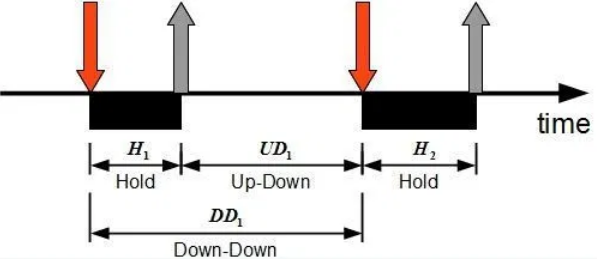

### a. First finding key hold times for a given data row:

In [7]:
def key_hold_times(datarow):
    output = []
    
    # loop through all tuples in data row
    for i in range(len(datarow)):
        # find only pairs for keys that are pressed
        if datarow[i][2] == "pressed":
            current_char = datarow[i][0].lower()
            # start looking for other half of pair from next index onwards
            for j in range(i + 1, len(datarow)):
                next_char = datarow[j][0].lower()
                # if they match, record differences in time
                if next_char == current_char:
                    output.append(("hold_"+ current_char, float(datarow[j][1]) - float(datarow[i][1])))
                    break
                    
    return output

Loop and print differences in key hold times between different data samples to make sure that they are small

In [8]:
# first for akshay's data
hold0 = key_hold_times(akshay_data[0])

hold1 = key_hold_times(akshay_data[1])

hold2 = key_hold_times(akshay_data[2])

print("differences in hold times between sample 0 and sample 1 in Akshay's data")
for i in range(len(hold0)):
    print(hold0[i][0], np.abs(round(hold0[i][1] - hold1[i][1], 5)))
    
print("\ndifferences in hold times between sample 1 and sample 2 in Akshay's data")
for i in range(len(hold0)):
    print(hold1[i][0], np.abs(round(hold1[i][1] - hold2[i][1], 5)))
    
print()
    
# then for mummy's data
hold0 = key_hold_times(mummy_data[0])

hold1 = key_hold_times(mummy_data[1])

hold2 = key_hold_times(mummy_data[2])

print("differences in hold times between sample 0 and sample 1 in Mummy's data")
for i in range(len(hold0)):
    print(hold0[i][0], np.abs(round(hold0[i][1] - hold1[i][1], 5)))
    
print("\ndifferences in hold times between sample 1 and sample 2 in Mummy's data")
for i in range(len(hold0)):
    print(hold1[i][0], np.abs(round(hold1[i][1] - hold2[i][1], 5)))

differences in hold times between sample 0 and sample 1 in Akshay's data
hold_. 0.012
hold_t 0.0041
hold_i 0.00833
hold_e 0.00801
hold_5 7e-05
hold_key.caps_lock 0.0
hold_r 0.02424
hold_key.caps_lock 0.0
hold_o 0.03309
hold_a 0.01938
hold_n 0.00071
hold_l 0.01002
hold_e 0.01616

differences in hold times between sample 1 and sample 2 in Akshay's data
hold_. 0.00386
hold_t 0.00012
hold_i 0.00382
hold_e 0.012
hold_5 0.00388
hold_key.caps_lock 1e-05
hold_r 0.01132
hold_key.caps_lock 0.0
hold_o 0.02083
hold_a 0.00062
hold_n 0.01138
hold_l 0.00794
hold_e 0.01592

differences in hold times between sample 0 and sample 1 in Mummy's data
hold_. 0.00746
hold_t 0.02398
hold_i 0.03182
hold_e 0.0278
hold_5 0.02793
hold_key.caps_lock 0.0
hold_r 0.00761
hold_key.caps_lock 0.0
hold_o 0.01209
hold_a 0.01177
hold_n 0.00052
hold_l 0.0004
hold_e 0.00794

differences in hold times between sample 1 and sample 2 in Mummy's data
hold_. 0.01872
hold_t 0.02782
hold_i 0.0398
hold_e 0.00786
hold_5 0.05188
hold_ke

Great, now we can confirm that hold times are a repeatable charactericstic of the way people type

### b. Next finding keydown-keydown times for a given data row:

In [9]:
def keydown_times(datarow):
    output = []
    
    # loop through all tuples in data row and keep only those that are "pressed"
    pressed = [x for x in datarow if x[2] == "pressed"]
    
    # find time between keydown of current key and keydown of next key
    for i in range(len(pressed) - 1):
        output.append(("dd_" + pressed[i][0] + pressed[i + 1][0], pressed[i + 1][1] - pressed[i][1]))
        
    return output

Loop and print differences in keydown-keydown times between different data samples to make sure that they are small

In [10]:
# first for akshay's data
keydown0 = keydown_times(akshay_data[0])

keydown1 = keydown_times(akshay_data[1])

keydown2 = keydown_times(akshay_data[2])

print("differences in keydown-keydown times between sample 0 and sample 1 in Akshay's data")
for i in range(len(keydown0)):
    print(keydown0[i][0], np.abs(round(keydown0[i][1] - keydown1[i][1], 5)))
    
print("\ndifferences in keydown-keydown times between sample 1 and sample 2 in Mummy's")
for i in range(len(keydown0)):
    print(keydown1[i][0], np.abs(round(keydown1[i][1] - keydown2[i][1], 5)))
    
print()

# first for mummy's data
keydown0 = keydown_times(mummy_data[0])

keydown1 = keydown_times(mummy_data[1])

keydown2 = keydown_times(mummy_data[2])

print("differences in keydown-keydown times between sample 0 and sample 1 in Akshay's")
for i in range(len(keydown0)):
    print(keydown0[i][0], np.abs(round(keydown0[i][1] - keydown1[i][1], 5)))
    
print("\ndifferences in keydown-keydown times between sample 1 and sample 2 in Mummy's")
for i in range(len(keydown0)):
    print(keydown1[i][0], np.abs(round(keydown1[i][1] - keydown2[i][1], 5)))


differences in keydown-keydown times between sample 0 and sample 1 in Akshay's data
dd_.t 0.01399
dd_ti 0.01825
dd_ie 0.01025
dd_e5 0.22685
dd_5Key.caps_lock 0.0365
dd_Key.caps_lockR 0.00855
dd_RKey.caps_lock 0.02839
dd_Key.caps_locko 0.02642
dd_oa 0.0633
dd_an 0.01954
dd_nl 0.00013
dd_le 0.01596

differences in keydown-keydown times between sample 1 and sample 2 in Mummy's
dd_.t 0.00107
dd_ti 0.00999
dd_ie 0.01812
dd_e5 0.09201
dd_5Key.caps_lock 0.02943
dd_Key.caps_lockR 0.02339
dd_RKey.caps_lock 0.01142
dd_Key.caps_locko 0.07128
dd_oa 0.03514
dd_an 0.02603
dd_nl 0.01945
dd_le 0.00387

differences in keydown-keydown times between sample 0 and sample 1 in Akshay's
dd_.t 1.90399
dd_ti 0.04981
dd_ie 0.47231
dd_e5 0.74285
dd_5Key.caps_lock 0.06208
dd_Key.caps_lockR 0.03677
dd_RKey.caps_lock 0.36854
dd_Key.caps_locko 0.23845
dd_oa 0.18335
dd_an 0.08391
dd_nl 0.05247
dd_le 0.06083

differences in keydown-keydown times between sample 1 and sample 2 in Mummy's
dd_.t 1.29238
dd_ti 0.04487
dd_i

Awesome, now we can confirm that keydown-keydown times are a repeatable charactericstic of the way people type

### c. Finally finding keyup-keydown times for a given data row:

In [11]:
# def keyup_keydown_times(datarow):
#     output = []
    
#     # loop through all tuples in data row and keep only pairs that are consectutively "released" then "pressed"
#     up_down = []
    
#     for i in range(len(datarow) - 1):
#         if datarow[i][2] == "released" and datarow[i+1][2] == "pressed":
#             up_down.append(datarow[i])
#             up_down.append(datarow[i+1])
            
#     # find time between keyup of current key and keydown of next key
#     for i in range(len(up_down) - 1):
#         output.append(("ud_" + up_down[i][0] + up_down[i + 1][0], up_down[i + 1][1] - up_down[i][1]))    
    
#     return output

# keyup_keydown_times(akshay_data[3]) 

Loop and print differences in keyup-keydown times between different data samples to make sure that they are small

In [12]:
# keyupdown0 = keyup_keydown_times(data[0])

# keyupdown1 = keyup_keydown_times(data[1])

# keyupdown2 = keyup_keydown_times(data[2])

# keyupdown3 = keyup_keydown_times(data[3])

# print([print(x) for x in keyupdown2])

# print("\n\n")

# print([print(x) for x in keyupdown3])

# # print("differences in keydown-keydown times between sample 0 and sample 1")
# # for i in range(len(keyupdown0)):
# #     print(keyupdown0[i][0], np.abs(round(keyupdown0[i][1] - keyupdown1[i][1], 5)))
    
# # print("\ndifferences in keydown-keydown times between sample 1 and sample 2")
# # for i in range(len(keyupdown0)):
# #     print(keyupdown1[i][0], np.abs(round(keyupdown1[i][1] - keyupdown2[i][1], 5)))

### d. Finding total typing time for a given data row:

In [13]:
def total_times(datarow):
    # key release time of last character - keydown time of first character
    return [("total_time", datarow[-1][1] - datarow[0][1])]

### Putting it all together and extracting features for all rows in data:

In [14]:
# first extract features and create tuples of descriptions alongside data
# done for clarity
def extract_features(data):
    tupled_data = [] # data with descriptions

    # loop through all rows in data
    for row in data:
        # extract features
        hold = key_hold_times(row)
        keydown = keydown_times(row)
        total = total_times(row)

        # store features in single list
        tupled_data += [hold + keydown + total]
    
    return tupled_data

mummy_tupled_data = extract_features(mummy_data)
dadda_tupled_data = extract_features(dadda_data)
akshay_tupled_data = extract_features(akshay_data)
julia_tupled_data = extract_features(julia_data)
test_tupled_data = extract_features(test_data)

# strip data of feature descriptions
def prepare_data(tupled_data):

    # final list of lists that will be inputted into a pandas dataframe
    output = []

    for row in tupled_data:
        new_row = []
        for item in row:
            new_row += [item[1]]

        output += [new_row]
        
    return output

mummy_input_data = prepare_data(mummy_tupled_data)
dadda_input_data = prepare_data(dadda_tupled_data)
akshay_input_data = prepare_data(akshay_tupled_data)
julia_input_data = prepare_data(julia_tupled_data)
test_input_data = prepare_data(test_tupled_data)

Keep track of feature names of model in features[]

In [15]:
features = [akshay_tupled_data[0][x][0] for x in range(len(akshay_tupled_data[0]))]

print("model's features are:\n", features)

model's features are:
 ['hold_.', 'hold_t', 'hold_i', 'hold_e', 'hold_5', 'hold_key.caps_lock', 'hold_r', 'hold_key.caps_lock', 'hold_o', 'hold_a', 'hold_n', 'hold_l', 'hold_e', 'dd_.t', 'dd_ti', 'dd_ie', 'dd_e5', 'dd_5Key.caps_lock', 'dd_Key.caps_lockR', 'dd_RKey.caps_lock', 'dd_Key.caps_locko', 'dd_oa', 'dd_an', 'dd_nl', 'dd_le', 'total_time']


### Label data by person who typed it

In [16]:
for row in mummy_input_data:
    row += [0]

for row in dadda_input_data:
    row += [1]

for row in akshay_input_data:
    row += [2]
    
for row in julia_input_data:
    row += [3]

for row in test_input_data:
    row += [-1] # label test_data as -1 because class is unknown

In [17]:
print(test_input_data)

[[0.11603211399999935, 0.10796978400000512, 0.14404928100000092, 0.12790484599999985, 0.1039022250000059, 3.173599999684029e-05, 0.1076030810000006, 6.254600000232813e-05, 0.1320381640000008, 0.12053240500000584, 0.07195199800000296, 0.13205024199999826, 0.09598974899999746, 0.6119846579999972, 0.20984939299999894, 0.1520270550000049, 0.859974011999995, 0.9466411750000034, 0.318369066999999, 0.5779962539999985, 0.3819223349999987, 0.36462131900000117, 0.3294282700000011, 0.3018782520000016, 0.5590360010000026, 5.70971754, -1], [0.06779790899999938, 0.06783977399999941, 0.06811580699999809, 0.06805827899999883, 0.07204506600000116, 4.524700000274606e-05, 0.0717432450000004, 1.0207999999067852e-05, 0.08797120199999853, 0.08387702899999994, 0.06339942200000337, 0.07992894799999561, 0.0757168080000028, 0.6738892400000012, 0.2929280339999991, 0.24811052100000097, 0.3959276989999978, 0.3926030929999982, 0.17559285800000168, 0.20485815600000024, 0.5169209109999997, 0.22109792100000192, 0.2589

# 3. Visualize features

Visualize key hold times for 5 rows of mummy's data

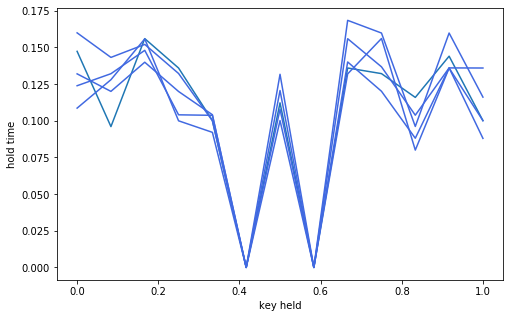

In [18]:
mummy_hold1 = mummy_input_data[10][:13]
mummy_hold2 = mummy_input_data[12][:13]
mummy_hold3 = mummy_input_data[14][:13]
mummy_hold4 = mummy_input_data[16][:13]
mummy_hold5 = mummy_input_data[18][:13]

x = np.linspace(0, 1, len(mummy_hold1))
y1 = mummy_hold1
y2 = mummy_hold2
y3 = mummy_hold3
y4 = mummy_hold4
y5 = mummy_hold5

fig, ax = plt.subplots(num = 1, figsize=(8, 5))
plt.plot(x, y1, label="royalblue")
plt.plot(x, y2, color='royalblue')
plt.plot(x, y3, color='royalblue')
plt.plot(x, y4, color='royalblue')
plt.plot(x, y5, color='royalblue')
plt.xlabel("key held")
plt.ylabel("hold time")

plt.show()

Visualize key hold times for 1 row of everyone's data

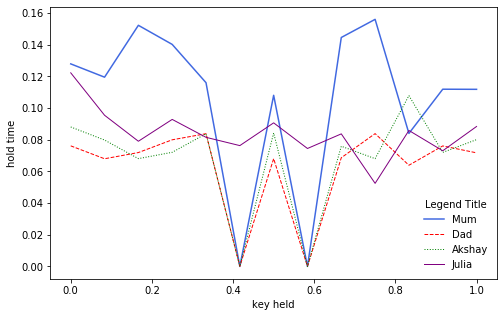

In [19]:
mummy_hold = mummy_input_data[7][:13]
dadda_hold = dadda_input_data[7][:13]
akshay_hold = akshay_input_data[7][:13]
julia_hold = julia_input_data[7][:13]

x = np.linspace(0, 1, len(akshay_hold))
y1 = mummy_hold
y2 = dadda_hold
y3 = akshay_hold
y4 = julia_hold

fig, ax = plt.subplots(num = 1, figsize=(8, 5))
ax.plot(x, y1, color="royalblue", label="Mum")
ax.plot(x, y2, color='red', linewidth=1.0, linestyle='--', label="Dad")
ax.plot(x, y3, color='green', linewidth=1.0, linestyle='dotted', label="Akshay")
ax.plot(x, y4, color='purple', linewidth=1.0, label="Julia")
plt.xlabel("key held")
plt.ylabel("hold time")

ax.legend(loc="lower right", title="Legend Title", frameon=False)

plt.show()

Visualize keydown-keydown times for 5 rows of mummy's data

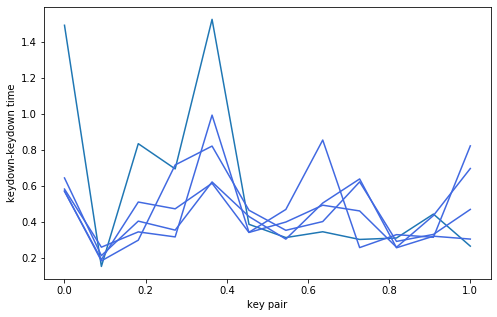

In [20]:
mummy_dd1 = mummy_input_data[10][13:25]
mummy_dd2 = mummy_input_data[12][13:25]
mummy_dd3 = mummy_input_data[14][13:25]
mummy_dd4 = mummy_input_data[16][13:25]
mummy_dd5 = mummy_input_data[18][13:25]

x = np.linspace(0, 1, len(mummy_dd1))
y1 = mummy_dd1
y2 = mummy_dd2
y3 = mummy_dd3
y4 = mummy_dd4
y5 = mummy_dd5

fig, ax = plt.subplots(num = 1, figsize=(8, 5))
ax.plot(x, y1, label="royalblue")
ax.plot(x, y2, color='royalblue')
ax.plot(x, y3, color='royalblue')
ax.plot(x, y4, color='royalblue')
ax.plot(x, y5, color='royalblue')
plt.xlabel("key pair")
plt.ylabel("keydown-keydown time")

plt.show()

Visualize keydown-keydown times for 1 row of everyone's data

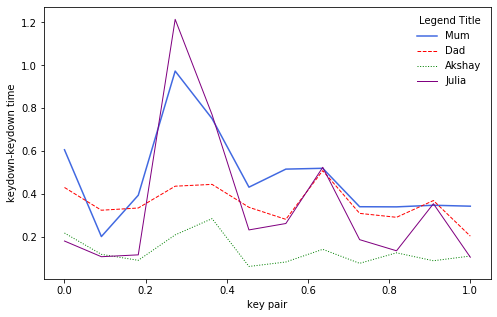

In [21]:
mummy_dd = mummy_input_data[5][13:25]
# mummy_total = mummy_input_data[5][25]

dadda_dd = dadda_input_data[5][13:25]
# dadda_total = dadda_input_data[5][25]

akshay_dd = akshay_input_data[5][13:25]
# akshay_total = akshay_input_data[5][25]

julia_dd = julia_input_data[5][13:25]

x = np.linspace(0, 1, len(akshay_dd))
y1 = mummy_dd
y2 = dadda_dd
y3 = akshay_dd
y4 = julia_dd

fig, ax = plt.subplots(num = 1, figsize=(8, 5))
plt.plot(x, y1, color="royalblue", label="Mum")
plt.plot(x, y2, color='red', linewidth=1.0, linestyle='--', label="Dad")
plt.plot(x, y3, color='green', linewidth=1.0, linestyle='dotted', label="Akshay")
plt.plot(x, y4, color='purple', linewidth=1.0, label="Julia")
plt.xlabel("key pair")
plt.ylabel("keydown-keydown time")

ax.legend(loc="upper right", title="Legend Title", frameon=False)

plt.show()

Visualize average total times for everyone's data

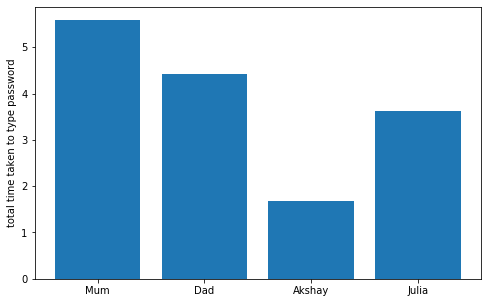

In [22]:
# find average of total time taken
mummy_sum = 0
for i in range(len(mummy_input_data)):
    mummy_sum += mummy_input_data[i][25]
mummy_avg_total = mummy_sum / len(mummy_input_data)

dadda_sum = 0
for i in range(len(dadda_input_data)):
    dadda_sum += dadda_input_data[i][25]
dadda_avg_total = dadda_sum / len(dadda_input_data)

akshay_sum = 0
for i in range(len(akshay_input_data)):
    akshay_sum += akshay_input_data[i][25]
akshay_avg_total = akshay_sum / len(akshay_input_data)

julia_sum = 0
for i in range(len(julia_input_data)):
    julia_sum += julia_input_data[i][25]
julia_avg_total = julia_sum / len(julia_input_data)

fig, ax = plt.subplots(num = 1, figsize=(8, 5))
people = ['Mum', 'Dad', 'Akshay', 'Julia']
avg_times = [mummy_avg_total, dadda_avg_total, akshay_avg_total, julia_avg_total]
ax.bar(people, avg_times)
plt.ylabel("total time taken to type password")
plt.show()

# 4. Loading data into Pandas dataframe

In [23]:
# combine input lists and then create a dataframe from them
# test data row are first 3 rows in dataframe
input_data = test_input_data + mummy_input_data + dadda_input_data + akshay_input_data + julia_input_data

print(len(input_data))

df = pd.DataFrame(input_data)

100


Let's add feature names as columns and see what the first few rows look like. The first row should have class -1 indicating it is the one that our machine learning model needs to classify.

In [24]:
# add label column for classification
df.columns = features + ["person"]

df[0:10]

,hold_.,hold_t,hold_i,hold_e,hold_5,hold_key.caps_lock,hold_r,hold_key.caps_lock,hold_o,hold_a,...,dd_5Key.caps_lock,dd_Key.caps_lockR,dd_RKey.caps_lock,dd_Key.caps_locko,dd_oa,dd_an,dd_nl,dd_le,total_time,person
0,0.116032,0.107970,0.144049,0.127905,0.103902,0.000032,0.107603,0.000063,0.132038,0.120532,...,0.946641,0.318369,0.577996,0.381922,0.364621,0.329428,0.301878,0.559036,5.709718,-1
1,0.067798,0.067840,0.068116,0.068058,0.072045,0.000045,0.071743,0.000010,0.087971,0.083877,...,0.392603,0.175593,0.204858,0.516921,0.221098,0.258904,0.419992,0.237049,4.113591,-1
2,0.100422,0.075966,0.059916,0.076050,0.071875,0.000007,0.087623,0.000012,0.074978,0.095479,...,0.316935,0.089889,0.087317,0.155538,0.056795,0.130554,0.079863,0.099999,1.875329,-1
3,0.131788,0.078899,0.072434,0.075436,0.090877,0.107636,0.130398,0.093227,0.062712,0.085740,...,1.036166,0.181495,0.147292,0.833466,0.155998,0.109070,0.669522,0.095640,4.321510,-1
4,0.148063,0.136035,0.144005,0.128157,0.083915,0.000012,0.111984,0.000007,0.124021,0.147937,...,0.829837,0.326219,0.195331,0.622605,0.330012,0.317945,0.318965,0.363914,4.941792,0
5,0.155526,0.112053,0.112183,0.155958,0.111840,0.000012,0.119592,0.000012,0.136108,0.159710,...,0.891918,0.362992,0.563876,0.384153,0.513359,0.234036,0.371435,0.303086,8.438720,0
6,0.136804,0.139872,0.151987,0.148100,0.059964,0.000011,0.128082,0.000012,0.152214,0.152026,...,1.602225,0.723702,0.312237,0.697645,0.306113,0.307994,0.357008,0.744996,7.494210,0
7,0.124064,0.131363,0.135914,0.128120,0.152073,0.000011,0.115910,0.000011,0.147957,0.140095,...,0.836579,0.348552,0.623631,0.513283,0.478874,0.194146,0.393758,0.379981,6.580654,0
8,0.122754,0.139658,0.142144,0.144093,0.123976,0.000013,0.108229,0.000012,0.128142,0.160041,...,1.433569,0.375159,0.651528,0.484538,0.332037,0.294113,0.335838,0.377089,5.830452,0
9,0.123981,0.108029,0.140053,0.104178,0.103937,0.000012,0.099892,0.000012,0.136811,0.136621,...,0.751394,0.431438,0.515684,0.519537,0.340171,0.339549,0.347054,0.342700,5.853207,0


In [25]:
df.tail()

,hold_.,hold_t,hold_i,hold_e,hold_5,hold_key.caps_lock,hold_r,hold_key.caps_lock,hold_o,hold_a,...,dd_5Key.caps_lock,dd_Key.caps_lockR,dd_RKey.caps_lock,dd_Key.caps_locko,dd_oa,dd_an,dd_nl,dd_le,total_time,person
95,0.127013,0.091625,0.069672,0.080536,0.083889,0.105332,0.127580,0.096102,0.070708,0.073702,...,1.012043,0.169378,0.141090,0.218636,0.102706,0.117613,0.366873,0.101447,3.092570,3
96,0.114116,0.092568,0.064934,0.066829,0.070718,0.090439,0.116706,0.100970,0.086775,0.074777,...,0.922403,0.190932,0.221844,0.163329,0.206406,0.097367,0.196599,0.126657,3.681962,3
97,0.109342,0.103332,0.076728,0.096564,0.100789,0.100940,0.127589,0.101018,0.077054,0.082411,...,0.815124,0.223323,0.142675,0.175925,0.115833,0.098458,0.169820,0.073346,2.532956,3
98,0.095918,0.108018,0.101538,0.065566,0.094279,0.084779,0.136055,0.115963,0.065558,0.077118,...,1.033895,0.177419,0.119238,0.181736,0.165433,0.101519,0.647066,0.083429,3.480429,3
99,0.091842,0.089433,0.067594,0.089722,0.083584,0.094685,0.109983,0.108172,0.072883,0.082578,...,0.356300,0.237012,0.140693,0.153292,0.122975,0.099050,0.144790,0.088736,2.190108,3


Double check that columns have the correct datatypes

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hold_.              100 non-null    float64
 1   hold_t              100 non-null    float64
 2   hold_i              100 non-null    float64
 3   hold_e              100 non-null    float64
 4   hold_5              100 non-null    float64
 5   hold_key.caps_lock  100 non-null    float64
 6   hold_r              100 non-null    float64
 7   hold_key.caps_lock  100 non-null    float64
 8   hold_o              100 non-null    float64
 9   hold_a              100 non-null    float64
 10  hold_n              100 non-null    float64
 11  hold_l              100 non-null    float64
 12  hold_e              100 non-null    float64
 13  dd_.t               100 non-null    float64
 14  dd_ti               100 non-null    float64
 15  dd_ie               100 non-null    float64
 16  dd_e5    

# 5. Splitting dataframe into labelled, unlabelled, test, and train data (and answer)

In [27]:
# classification mapping 0: "mummy", 1: "dadda", 2: "akshay"
targets = ["mummy", "dadda", "akshay", "julia"]

# We first split our dataframe into X (inputs) and y (outputs/targets)
X_all_df = df.drop("person", axis=1)
y_all_df = df["person"] 

# The data is currently in pandas "dataframes," but needs to be in numpy arrays
# These next two lines convert two dataframes to numpy arrays (using .values)
X_all = X_all_df.values
y_all = y_all_df.values    

X_unlabeled = X_all[:4,:]  # "unknown" status
y_unlabeled = y_all[:4]

X_labeled = X_all[4:,:]    # known status
y_labeled = y_all[4:]   

# we can scramble the data - but only the labeled data!
# Notice that, here, we will _only_ use cross-validation for model-buidling
#   (We won't include a separate X_train X_test split.)
indices = np.random.permutation(len(X_labeled))  # this scrambles the data each time
X_train = X_labeled[indices]
y_train = y_labeled[indices]

# ------ answer setup ------
answers = [0, 1, 2, 3]

# 6. Classify test data

### Build a kNN model

In [28]:
# Create a kNN model and tune its parameters 
# There is only one parameter, k, the number of neighbors considered...

# The lab problem (hw4pr1) asks you to create a loop around this cross-validation piece...
# 
# Let k be your loop variable and print all of the results!

# cross-validation:
# This runs a routine that splits only the training set into two pieces:
# model-building and model-validation. We'll use "build" and "validate"

max_av = 0                                 # keep track of highest mean cross-validation score
best_k = 0                                 # keep track of k that gave highest mean cross-validation score

for k in range(30):
  # discard even k values beacuse they will cause ties
  if k % 2 != 0:
    # build model
    knn = KNeighborsClassifier(n_neighbors=k)   # here, k is the "k" in kNN
    # test cross validation scores
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5) # cv is the number of splits
    # find mean score
    av = cv_scores.mean()
    print("k =", k, ", CV =", av)
    # record k if mean score is highest seen 
    if av > max_av:
        max_av= av
        best_k = k

print()
print("best k is: ", best_k)

# now, train a new model with ALL of the training data...
# using the best value of k, best_k...
# and use this model to predict the labels of the test set
#
# this is a new model! line is where the full training data is used for the model
knn_train = KNeighborsClassifier(n_neighbors=best_k)   # now using the best_k
knn_train.fit(X_labeled, y_labeled)                        # using all of the labelled training data

# Now, run our test set!
print("The predicted outputs are")
predicted_labels = knn_train.predict(X_unlabeled)
print(predicted_labels)

k = 1 , CV = 0.9284210526315789
k = 3 , CV = 0.9063157894736842
k = 5 , CV = 0.8963157894736842
k = 7 , CV = 0.9063157894736842
k = 9 , CV = 0.8852631578947369
k = 11 , CV = 0.8642105263157894
k = 13 , CV = 0.8536842105263158
k = 15 , CV = 0.8436842105263158
k = 17 , CV = 0.8126315789473683
k = 19 , CV = 0.8121052631578947
k = 21 , CV = 0.7810526315789474
k = 23 , CV = 0.74
k = 25 , CV = 0.7089473684210527
k = 27 , CV = 0.7089473684210527
k = 29 , CV = 0.7089473684210527

best k is:  1
The predicted outputs are
[0 1 2 1]


### Build a decision tree model

Create a decision tree visualization if you'd like

In [29]:
# # show the creation of a tree file at max_depth = 5
# # the DT classifier
# dtree = tree.DecisionTreeClassifier(max_depth=20)

# # train it (build the tree)
# dtree = dtree.fit(X_train, y_train) 

# # use model to predict unlabeled typing data
# predicted_labels_tree = dtree.predict(X_unlabeled)

# for i in range(len(predicted_labels_tree)):
#     print("person", i, "is", targets[predicted_labels_tree[i]])

# # write out the dtree to tree.dot (or another filename of your choosing...)
# filename = 'typing_tree.dot'
# tree.export_graphviz(dtree, out_file=filename,   # the filename constructed above...!
#                         feature_names=features,  filled=True, 
#                         rotate=False, # True for Left-to-Right; False for Up-Down
#                         class_names=targets, 
#                         leaves_parallel=True )  # lots of options!
# #
# # Visualize the resulting graph (tree) at www.webgraphviz.com
# #
# print("Wrote the file", filename)

In [30]:
#
# cross-validation and scoring to determine parameter: max_depth
# 

best_depth = 0
best_score = 0

# forcing decision tree to have at least max_depth = 5, and at most 20
for max_depth in range(5,12):
    # create our classifier
    dtree = tree.DecisionTreeClassifier(max_depth=max_depth)
    #
    # cross-validate to tune our model (this week, all-at-once)
    #
    scores = cross_val_score(dtree, X_train, y_train, cv=5)
    average_cv_score = scores.mean()

    print("      Scores:", scores)
    print("For depth=", max_depth, "average CV score = ", average_cv_score)  

    if average_cv_score > best_score:
        best_depth= max_depth
        best_score = average_cv_score
    
# choose a maximum depth based on cross-validation... 
print()
print("For depth =", best_depth, "best CV score =", best_score) 

# now, train the model with ALL of the training data...  and predict the unknown labels
dtree = tree.DecisionTreeClassifier(max_depth=best_depth)
dtree = dtree.fit(X_train, y_train) 

# feature importances
print("\ndtree.feature_importances_ are\n      ", dtree.feature_importances_) 
print("Order:", features)
print()

# use model to predict unlabeled typing data
predicted_labels_tree = dtree.predict(X_unlabeled)

for i in range(len(predicted_labels_tree)):
    print("person", i, "is", targets[predicted_labels_tree[i]])

      Scores: [0.8        0.94736842 0.84210526 1.         0.94736842]
For depth= 5 average CV score =  0.9073684210526316
      Scores: [0.8        0.94736842 0.84210526 0.94736842 0.94736842]
For depth= 6 average CV score =  0.8968421052631579
      Scores: [0.9        0.84210526 0.89473684 1.         1.        ]
For depth= 7 average CV score =  0.9273684210526316
      Scores: [0.85       0.89473684 0.84210526 1.         1.        ]
For depth= 8 average CV score =  0.9173684210526316
      Scores: [0.85       0.94736842 0.84210526 1.         1.        ]
For depth= 9 average CV score =  0.9278947368421052
      Scores: [0.85       0.89473684 0.84210526 1.         0.94736842]
For depth= 10 average CV score =  0.906842105263158
      Scores: [0.9        0.89473684 0.84210526 0.94736842 1.        ]
For depth= 11 average CV score =  0.9168421052631579

For depth = 9 best CV score = 0.9278947368421052

dtree.feature_importances_ are
       [0.         0.         0.         0.         0.  

### Build a random forest model

In [31]:
# Again, we will use cross-validation to determine the Random Forest's two hyperparameters:
#   + max_depth
#   + n_estimators
#
# (We will not have an X_train vs. X_test split in addition.)

best_depth = 1
best_n = 1
best_score = 0

# forcing random forest to have at least max_depth = 5, and at most 20
for max_depth in range(3,12):
      for n_estimators in range(5,50,5):
        # create our classifier
        rforest = ensemble.RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)

        # cross-validate to tune our model (this week, all-at-once)
        scores = cross_val_score(rforest, X_train, y_train, cv=5)
        average_cv_score = scores.mean()

        # find best maximum depth and number of trees in forest
        if average_cv_score > best_score:
              best_score = average_cv_score
              best_depth = max_depth
              best_n = n_estimators

          # print("      Scores:", scores)
          # print("For depth=", max_depth, "average CV score = ", average_cv_score) 

print("For depth =", best_depth, "and number of trees =", best_n, "best CV score =", best_score) 

#
# now, train the model with ALL of the training data...  and predict the labels of the test set
#

# these next lines is where the full training data is used for the model
print()
rforest = ensemble.RandomForestClassifier(max_depth=best_depth, n_estimators=best_n)
rforest = rforest.fit(X_train, y_train) 

# feature importances
print("\nrforest.feature_importances_ are\n      ", rforest.feature_importances_) 
print("Order:", features)
print()

# use model to predict unlabeled typing data
predicted_labels_forest = rforest.predict(X_unlabeled)

for i in range(len(predicted_labels_forest)):
    print("person", i, "is", targets[predicted_labels_forest[i]])

For depth = 3 and number of trees = 5 best CV score = 1.0


rforest.feature_importances_ are
       [0.         0.         0.         0.         0.         0.00577948
 0.         0.0446898  0.08695327 0.         0.1153159  0.06186694
 0.06708607 0.         0.13871953 0.07358679 0.         0.07315651
 0.07162151 0.00590561 0.         0.         0.04811373 0.15071766
 0.0564872  0.        ]
Order: ['hold_.', 'hold_t', 'hold_i', 'hold_e', 'hold_5', 'hold_key.caps_lock', 'hold_r', 'hold_key.caps_lock', 'hold_o', 'hold_a', 'hold_n', 'hold_l', 'hold_e', 'dd_.t', 'dd_ti', 'dd_ie', 'dd_e5', 'dd_5Key.caps_lock', 'dd_Key.caps_lockR', 'dd_RKey.caps_lock', 'dd_Key.caps_locko', 'dd_oa', 'dd_an', 'dd_nl', 'dd_le', 'total_time']

person 0 is mummy
person 1 is dadda
person 2 is akshay
person 3 is julia
